## SongRMG

In [1]:
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import time
import cmath
import warnings

### gen_src()

In [2]:
"""
Coded by Song, S.G. (August 2022)

Basic input parameters to describe a finite source model

function [rup] = gen_src(rup)
"""

rup={}

# Basic information for an event
rup["outfl"] = 'rup_test.mat'

rup["target_Mw"] = 6.6

rup["target_Mo"] = 10.**(1.5*rup["target_Mw"] + 9.05)   # Mo in Nm

rup["num"] = 3        # number of simulation

rup["seed"] = {"seed": 1999, "hypo": 1999}

rup["elon"] = -118.515  # longitude, top center of the fault plane in degree
rup["elat"] =   34.344  # latitude,  top center of the fault plane in degree

rup["L"] = 20.       # fault length (along-strike) in km
rup["W"] = 20.        # fault width (along-dip) in km

rup["stk"]  = 0.        # strike in deg.
rup["dip"]  = 90.       # dip in deg.
rup["rak"]  = 180.      # rake in deg.

rup["dtop"] = 0.        # depth to top of fault
#rand('state',rup.seed.hypo);
#rup["shyp"] = np.zeros(rup["num"]) 
#rup["dhyp"] = np.zeros(rup["num"]) 

rup["shyp"] = (np.random.rand(rup["num"]) - 0.5)*rup["L"]*0.8  # along strike location (from top center) of hypocenter
rup["dhyp"] = (np.random.rand(rup["num"])*0.8+0.1)*rup["W"]    # along dip location (from top edge) of hypocenter

rup["dx"]  = 0.2      # grid size (along-strike) in km
rup["dz"]  = 0.2      # grid size (along-dip) in km

rup["dx1"] = 0.5      # grid size for sub-calculation (Chol, Eig)
rup["dz1"] = 0.5      # grid size for sub-calculation

rup["svf"] = {"type": 'etinti', "dt": 0.02}   # currently 'tri','rec','pliu', 'etinti' available

### End of inputs~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

rup["nx"] = int(np.ceil(rup["L"]/rup["dx"]))
rup["nz"] = int(np.ceil(rup["W"]/rup["dz"]))

rup["nx1"] = int(np.ceil(rup["L"]/rup["dx1"]))
rup["nz1"] = int(np.ceil(rup["W"]/rup["dz1"]))

rup["lx"] = [0]*rup["num"]
rup["lz"] = [0]*rup["num"]
rup["lx1"] = [0]*rup["num"]
rup["lz1"] = [0]*rup["num"]
rup["dis"] = [0]*rup["num"]
for inum in range(rup["num"]):

  rup["lx"][inum] = np.arange(rup["dx"]/2,rup["dx"]*rup["nx"],rup["dx"]) - (rup["nx"]*rup["dx"]/2 + rup["shyp"][inum])
  rup["lz"][inum] = np.arange(rup["dz"]/2,rup["dz"]*rup["nz"],rup["dx"]) - rup["dhyp"][inum]
  
  rup["lx1"][inum] = np.arange(rup["dx1"]/2,rup["dx1"]*rup["nx1"],rup["dx1"]) - (rup["nx1"]*rup["dx1"]/2 + rup["shyp"][inum])
  rup["lz1"][inum] = np.arange(rup["dz1"]/2,rup["dz1"]*rup["nz1"],rup["dz1"]) - rup["dhyp"][inum]
  
  rup["lx1"][inum] = np.append((rup["lx1"][inum][0]-rup["dx1"]), rup["lx1"][inum]) 
  rup["lx1"][inum] = np.append(rup["lx1"][inum], (rup["lx1"][inum][-1]+rup["dx1"]))
  rup["lz1"][inum] = np.append((rup["lz1"][inum][0]-rup["dz1"]), rup["lz1"][inum])
  rup["lz1"][inum] = np.append(rup["lz1"][inum], (rup["lz1"][inum][-1]+rup["dz1"]))
  
  [XX, ZZ] = np.meshgrid(rup["lx"][inum],rup["lz"][inum])
  rup["dis"][inum] = np.sqrt(XX**2 + ZZ**2)  # distance from the nucleation point on the fault plane


rup["nx1"] = rup["nx1"] + 2
rup["nz1"] = rup["nz1"] + 2

### gen_stats()

In [3]:
"""
Coded by Song, S. (April. 2013)
Set up target 1-point and 2-point statistics

function [rup] = gen_stats(rup)
""" 

# [slip Vr Vmax risT]
rup["p1"]={}
rup["p1"]["min"] = [0.,   1., 1., 0.2]
rup["p1"]["max"] = [500., 6., 500., 5.]

rup["lambda"] = 1. # min wavelength = 10 km
rup["fN"] = 6

rup["p2"] = {}
rup["p2"]["tag"] = 'positive_eigen'

rup["Nstats"] = 1000;
rup["stats_id"] = 200;

rup["seed"]["stats"] = 1999;

rup["mu"] = 33e9;

A = rup["L"]*rup["W"]*1.e6
mu_slip = rup["target_Mo"]/rup["mu"]/A*100. # meter to cm

In [4]:
# Constants from src_stats_mod.mat
mu_ax = [1.5329, 1.4496, 1.7063, 1.2242, 1.5395, 1.6174]
mu_az = [1.2215, 1.0458, 1.0519, 1.0540, 0.8088, 1.0153]
mu_cc = [0.5807, 0.7681, 0.6343]
mu_mu = [115.2695, 2.0327, 111.6469]
mu_sig = [58.8421, 0.7846, 78.9101]

sig_ax = [0.4864, 0.8706, 0.8875, 0.5799, 1.0582, 0.7069]
sig_az = [0.7453, 0.9564, 0.8797, 0.5549, 0.8503, 0.5774]
sig_cc = [0.1231, 0.0874, 0.1164]
sig_mu = [39.7429, 0.2514, 31.9504]
sig_sig = [22.9453, 0.1122, 27.0968]

C = [[1.0000, 0.0351, 0.6673, 0.9803, 0.2617, 0.6657, -0.1094,
      -0.0136, -0.1807, 0.0021, -0.0622, -0.2019, 0.5704, 0.3749,
      0.4942, 0.1264, 0.1764, 0.1810, 0.3585, -0.2776, 0.2169],
     [0.0351, 1.0000, 0.4690, 0.0608, 0.3916, 0.3144, 0.0745,
      0.2339, 0.0862, 0.3514, 0.3348, 0.2345, 0.0086, -0.1889,
      0.0396, -0.2999, -0.2126, -0.1075, -0.1158, 0.3768, -0.3763],
     [0.6673, 0.4690, 1.0000, 0.6760, 0.1915, 0.9213, 0.1151,
      0.3258, 0.0969, 0.4111, 0.4195, 0.0421, 0.2675, 0.0019,
      0.2679, -0.2285, 0.0404, 0.1922, 0.4571, -0.0356, 0.2327],
     [0.9803, 0.0608, 0.6760, 1.0000, 0.2641, 0.6988, -0.0773,
      -0.0106, -0.1464, 0.0092, -0.0255, -0.1432, 0.5238, 0.3484,
      0.4867, 0.1499, 0.1806, 0.2068, 0.3694, -0.1675, 0.2355],
     [0.2617, 0.3916, 0.1915, 0.2641, 1.0000, 0.2469, -0.2244,
      -0.2883, -0.3076, -0.1196, -0.1709, -0.2304, 0.2745, 0.3352,
      0.3204, 0.2161, 0.2028, 0.1481, -0.0627, 0.1207, -0.3495],
     [0.6657, 0.3144, 0.9213, 0.6988, 0.2469, 1.0000, 0.0727,
      0.1566, 0.0476, 0.2599, 0.3412, 0.0322, 0.2397, 0.0994,
      0.2816, -0.0514, 0.1232, 0.2563, 0.5068, -0.0576, 0.2777],
     [-0.1094, 0.0745, 0.1151, -0.0773, -0.2244, 0.0727, 1.0000,
      0.5633, 0.6220, 0.3922, 0.4548, 0.4867, -0.2456, -0.3080,
      -0.2000, -0.3335, -0.2204, -0.2238, 0.1223, 0.1121, 0.2360],
     [-0.0136, 0.2339, 0.3258, -0.0106, -0.2883, 0.1566, 0.5633,
      1.0000, 0.5692, 0.6432, 0.6992, 0.3994, -0.1658, -0.3600,
      -0.1948, -0.5043, -0.2639, -0.2222, 0.1836, 0.0165, 0.2772],
     [-0.1807, 0.0862, 0.0969, -0.1464, -0.3076, 0.0476, 0.6220,
      0.5692, 1.0000, 0.3915, 0.5456, 0.5740, -0.2986, -0.3650,
      -0.3755, -0.4064, -0.3091, -0.2343, -0.0003, 0.0209, 0.0343],
     [0.0021, 0.3514, 0.4111, 0.0092, -0.1196, 0.2599, 0.3922,
      0.6432, 0.3915, 1.0000, 0.7637, 0.5002, -0.0948, -0.2817,
      -0.0153, -0.4343, -0.1754, -0.0763, 0.1807, 0.0773, 0.1505],
     [-0.0622, 0.3348, 0.4195, -0.0255, -0.1709, 0.3412, 0.4548,
      0.6992, 0.5456, 0.7637, 1.0000, 0.6543, -0.2287, -0.3714,
      -0.2375, -0.4589, -0.2221, -0.1780, 0.1993, 0.0458, 0.2033],
     [-0.2019, 0.2345, 0.0421, -0.1432, -0.2304, 0.0322, 0.4867,
      0.3994, 0.5740, 0.5002, 0.6543, 1.0000, -0.2518, -0.3249,
      -0.2753, -0.3914, -0.2784, -0.2883, 0.0099, 0.1892, 0.0639],
     [0.5704, 0.0086, 0.2675, 0.5238, 0.2745, 0.2397, -0.2456,
      -0.1658, -0.2986, -0.0948, -0.2287, -0.2518, 1.0000, 0.5875,
      0.5187, 0.2251, 0.3262, 0.1950, 0.2035, -0.1137, -0.0447],
     [0.3749, -0.1889, 0.0019, 0.3484, 0.3352, 0.0994, -0.3080,
      -0.3600, -0.3650, -0.2817, -0.3714, -0.3249, 0.5875, 1.0000,
      0.4580, 0.4671, 0.4855, 0.2041, 0.0488, -0.2098, -0.0927],
     [0.4942, 0.0396, 0.2679, 0.4867, 0.3204, 0.2816, -0.2000,
      -0.1948, -0.3755, -0.0153, -0.2375, -0.2753, 0.5187, 0.4580,
      1.0000, 0.3694, 0.4056, 0.4700, 0.1531, 0.0067, 0.0377],
     [0.1264, -0.2999, -0.2285, 0.1499, 0.2161, -0.0514, -0.3335,
      -0.5043, -0.4064, -0.4343, -0.4589, -0.3914, 0.2251, 0.4671,
      0.3694, 1.0000, 0.4558, 0.3702, -0.0696, -0.0459, -0.0714],
     [0.1764, -0.2126, 0.0404, 0.1806, 0.2028, 0.1232, -0.2204,
      -0.2639, -0.3091, -0.1754, -0.2221, -0.2784, 0.3262, 0.4855,
      0.4056, 0.4558, 1.0000, 0.6706, 0.1294, -0.1370, 0.0518],
     [0.1810, -0.1075, 0.1922, 0.2068, 0.1481, 0.2563, -0.2238,
      -0.2222, -0.2343, -0.0763, -0.1780, -0.2883, 0.1950, 0.2041,
      0.4700, 0.3702, 0.6706, 1.0000, 0.1610, 0.0159, 0.0401],
     [0.3585, -0.1158, 0.4571, 0.3694, -0.0627, 0.5068, 0.1223,
      0.1836, -0.0003, 0.1807, 0.1993, 0.0099, 0.2035, 0.0488,
      0.1531, -0.0696, 0.1294, 0.1610, 1.0000, 0.1075, 0.7584],
     [-0.2776, 0.3768, -0.0356, -0.1675, 0.1207, -0.0576, 0.1121,
      0.0165, 0.0209, 0.0773, 0.0458, 0.1892, -0.1137, -0.2098,
      0.0067, -0.0459, -0.1370, 0.0159, 0.1075, 1.0000, -0.0486],
     [0.2169, -0.3763, 0.2327, 0.2355, -0.3495, 0.2777, 0.2360,
      0.2772, 0.0343, 0.1505, 0.2033, 0.0639, -0.0447, -0.0927,
      0.0377, -0.0714, 0.0518, 0.0401, 0.7584, -0.0486, 1.0000]]

L = np.linalg.cholesky(C)

N = len(C)

#randn('state',rup.seed.stats); 
s = np.zeros([N, rup["Nstats"]])
for i in range(rup["Nstats"]):
  
  s[:,i] = np.random.randn(N)
  
  s[0,i] = (mu_slip-mu_mu[0])/sig_mu[0]/L[0,0]  # Conditioning on a specific value of slip...

  s[:,i] = np.dot(L, s[:,i])

  s[:,i] = s[:,i]*np.concatenate((sig_mu, sig_sig, sig_ax, sig_az, sig_cc)) + np.concatenate((mu_mu, mu_sig, mu_ax, mu_az, mu_cc))

  s[6:18,i] = np.exp(s[6:18,i])  # Transforming to Lognormal distribution...
    
  
rup["stats"] = s.T


In [5]:
### 1-point and 2-point statistics of source parameters

### Sampling input 1-point and 2-point statistics, given the source statistics model

rup["p1"]["mu"] =  [rup["stats"][rup["stats_id"],0], rup["stats"][rup["stats_id"],1]*1.5, rup["stats"][rup["stats_id"],2]]
rup["p1"]["sig"] = [rup["stats"][rup["stats_id"],3], rup["stats"][rup["stats_id"],4]*1.5, rup["stats"][rup["stats_id"],5]]


rup["p2"]["ax"] = [[rup["stats"][rup["stats_id"],6], rup["stats"][rup["stats_id"],7], rup["stats"][rup["stats_id"],8]], 
                   [np.nan,                          rup["stats"][rup["stats_id"],9], rup["stats"][rup["stats_id"],10]], 
                   [np.nan,                          np.nan,                          rup["stats"][rup["stats_id"],11]]]

rup["p2"]["az"] = [[rup["stats"][rup["stats_id"],12], rup["stats"][rup["stats_id"],13], rup["stats"][rup["stats_id"],14]], 
                   [np.nan,                           rup["stats"][rup["stats_id"],15], rup["stats"][rup["stats_id"],16]], 
                   [np.nan,                           np.nan,                           rup["stats"][rup["stats_id"],17]]]


rup["p2"]["cc"] = [[1.,     rup["stats"][rup["stats_id"],18], rup["stats"][rup["stats_id"],19]], 
                   [np.nan, 1.,                               rup["stats"][rup["stats_id"],20]], 
                   [np.nan, np.nan,                           1.]]
   

rup["p2"]["RDx"] = [[0., 0., 0.], [np.nan, 0., 0.], [np.nan, np.nan, 0.]]
rup["p2"]["RDz"] = [[0., 0., 0.], [np.nan, 0., 0.], [np.nan, np.nan, 0.]]

In [6]:
rup["p1"]

{'min': [0.0, 1.0, 1.0, 0.2],
 'max': [500.0, 6.0, 500.0, 5.0],
 'mu': [67.51901046467758, 2.6710575396469527, 67.33534404451458],
 'sig': [26.032939550623965, 1.074831498020843, 36.17244382276326]}

In [7]:
rup["p2"]

{'tag': 'positive_eigen',
 'ax': [[3.759632822534567, 1.9722726414162945, 4.816101957509835],
  [nan, 5.933146985853731, 6.240093734280703],
  [nan, nan, 11.025370607832686]],
 'az': [[4.266108519228822, 9.66549060381116, 2.0103233783458885],
  [nan, 2.269448036101786, 2.099198783755591],
  [nan, nan, 1.781205063438377]],
 'cc': [[1.0, 0.5266692057412209, 0.6892992620776835],
  [nan, 1.0, 0.5325677713102175],
  [nan, nan, 1.0]],
 'RDx': [[0.0, 0.0, 0.0], [nan, 0.0, 0.0], [nan, nan, 0.0]],
 'RDz': [[0.0, 0.0, 0.0], [nan, 0.0, 0.0], [nan, nan, 0.0]]}

### gen_rup()

In [8]:
"""
Coded by Song, S.G. (August 2022)
Rupture model generator based on 1-point and 2-point statistics 
of key kinematic source parameters
"""

#par.tag = 'Additional Parameters'


# Step I: 2-point statistics
# generate 2D distributions of source parameters 
# assuming multi-variate Gaussian with zero mean and unit std
print('   ')
print('### Step I: 2-point statistics   ')
print('### generating 2D distributions of source parameters')
print('### based on covariance matrix constructed from     ')
print('### auto- and cross-correlation ')
print('   ')

t1 = time.time()

N  = rup["nx"]*rup["nz"]
N1 = rup["nx1"]*rup["nz1"]

print("=> Number of subfaults (fine grid): {:d}".format(N))
print('  ')

print("=> Number of subfaults (coarse grid): {:d}".format(N1))
print('  ')

[XX, ZZ] = np.meshgrid(rup["lx1"][0],rup["lz1"][0])

X = XX.flatten(order='F')
Z = ZZ.flatten(order='F')

Z1 = np.tile(Z, (N1,1)).T
#del Z

r_z = (Z1.T - Z1)
#del Z1  
        
X1 = np.tile(X, (N1,1)).T
#del X

r_x = (X1.T - X1)
#del X1  

### Coded by Song, S. (Feb. 2010)
### Generate spatial coherence structure
### Currently exponential function only
# function [rho] = gen_rho(rup,r)

N = len(rup["p1"]["mu"])

rho = [0]*N
for k in range(N):
    
    rho[k] = [0]*N
    for i in range(k,N):
        
      rho[k][i] = np.exp(-np.sqrt(((r_x-rup["p2"]["RDx"][k][i])/rup["p2"]["ax"][k][i])**2 \
                                + ((r_z-rup["p2"]["RDz"][k][i])/rup["p2"]["az"][k][i])**2))
                         
      rho[k][i] = rup["p2"]["cc"][k][i]*rho[k][i]
            

#del r_z, r_x

Cm = np.vstack([np.hstack([rho[0][0], rho[0][1], rho[0][2]]),
                np.hstack([rho[0][1].T, rho[1][1], rho[1][2]]),
                np.hstack([rho[0][2].T, rho[1][2].T, rho[2][2]])])

#del rho

t2 = time.time()
print("=> Elapsed time for constructing Cm: {:10.2f}".format(t2-t1))


#removing negative eigen values for positivity constraints
[eig_d, eig_v] = np.linalg.eig(Cm)

rup["eigen"] = eig_d

eig_d[eig_d < 0.01] = 0.01

Cm = np.dot(np.dot(eig_v,np.diag(eig_d)),eig_v.T)

t3 = time.time() 
print("=> Elapsed time for Eigen decomposition: {:10.2f}".format(t3-t2))


L = np.linalg.cholesky(Cm)
#del Cm

t4 = time.time()
print("=> Elapsed time for Cholesky factorization: {:10.2f}".format(t4-t3))

#randn('state',rup.seed.seed);
rup["slip1"] = [0]*rup["num"]
rup["Vr1"] = [0]*rup["num"]
rup["psv1"] = [0]*rup["num"]
for iter in range(rup["num"]): 
  
  s0 = np.random.randn(3*N1,1)
  s = np.dot(L,s0) 
  #del L

  slip1 = s[0:N1]
  Vr1   = s[N1:2*N1]
  psv1 = s[2*N1:]

  slip1 = slip1.reshape(rup["nz1"],rup["nx1"], order='F')
  Vr1   = Vr1.reshape(rup["nz1"],rup["nx1"], order='F')
  psv1  = psv1.reshape(rup["nz1"],rup["nx1"], order='F')
 
  rup["slip1"][iter] = slip1  
  rup["Vr1"][iter]   = Vr1    
  rup["psv1"][iter]  = psv1


t5 = time.time() 
print("=> Elapsed time for random sampling: {:10.2f}".format(t5-t4))

###Interpolation
rup["slip"] = [0]*rup["num"]
rup["Vr"] = [0]*rup["num"]
rup["psv"] = [0]*rup["num"]
for iter in range(rup["num"]):
   
  [X, Z] = np.meshgrid(rup["lx"][iter],rup["lz"][iter])
  [X1, Z1] = np.meshgrid(rup["lx1"][iter],rup["lz1"][iter])
    
  rup["slip"][iter] = griddata((X1.flatten(), Z1.flatten()),rup["slip1"][iter].flatten(),(X[0][None, :], Z.T[0][:, None]))
  rup["Vr"][iter]   = griddata((X1.flatten(), Z1.flatten()),rup["Vr1"][iter].flatten(),(X[0][None, :], Z.T[0][:, None]))
  rup["psv"][iter]  = griddata((X1.flatten(), Z1.flatten()),rup["psv1"][iter].flatten(),(X[0][None, :], Z.T[0][:, None]))

   
### Step I: 2-point statistics   
### generating 2D distributions of source parameters
### based on covariance matrix constructed from     
### auto- and cross-correlation 
   
=> Number of subfaults (fine grid): 10000
  
=> Number of subfaults (coarse grid): 1764
  
=> Elapsed time for constructing Cm:       0.52
=> Elapsed time for Eigen decomposition:      30.12
=> Elapsed time for Cholesky factorization:       0.28
=> Elapsed time for random sampling:       0.02


In [10]:
def b_taper(nz,nx,dtop):

#  nz = 30
#  nx = 100

#  dtop = 3.
    
  nz_bt = round(nz/5)
  nx_bt = round(nx/5)

  sfac = np.ones((nz,nx))
  
  x = np.linspace(0,1,nx_bt)
  z = np.linspace(0,1,nz_bt)

  sfac_x = np.sqrt(1-x**2).reshape(1,len(x))
  sfac_z = np.sqrt(1-z**2).reshape(len(z),1)


  if dtop < 0.1:
    
    sfac_x = np.hstack((np.tile(np.fliplr(sfac_x),(nz,1)), np.ones((nz,nx-2*nx_bt)), np.tile(sfac_x,(nz,1))))
    sfac_z = np.vstack((np.ones((nz-nz_bt,nx)), np.tile(sfac_z,(1,nx))))
    
  else:
   
    sfac_x = np.hstack((np.tile(np.fliplr(sfac_x),(nz,1)), np.ones((nz,nx-2*nx_bt)), np.tile(sfac_x,(nz,1))))
    sfac_z = np.vstack((np.tile(np.flipud(sfac_z),(1,nx)), np.ones((nz-2*nz_bt,nx)), np.tile(sfac_z,(1,nx))))

  sfac = sfac_x*sfac_z

  return sfac

In [11]:
def slip_to_Mo(slip, W, L):

# compute Mo for a given slip distribution
#
# INPUT:  slip in cm  
#         dim in km [W L]
#
# OUTPUT: Mo in Nm

  mu = 3.3*1e10
  s = slip.mean()/100  # average slip in m  
  A = L*W*1e6

  Mo = mu*s*A

  return Mo

In [12]:
#Step II: 1-point statistics
#currently we assume the Gaussian distribution 
print('   ')
print('### Step II: 1-point statistics   ')
print('### Adjust 1-point statistics, e.g., mean and sigma')
print('### Currently assume Gaussian distribution         ')
print('### But it can be transformed into non Gaussian distribution')
print('### if necessary   ')
print('   ')

t1 = time.time() 
rup["p1"]["mu1"] = np.zeros((rup["num"],len(rup["p1"]["mu"])+1))
rup["p1"]["sig1"] = np.zeros((rup["num"],len(rup["p1"]["sig"])+1))

rup["Mo"] = [0]*rup["num"]
rup["Mw"] = [0]*rup["num"]
rup["risT"] = [0]*rup["num"]
for iter in range(rup["num"]):
  
  # Slip  
  # fixing mean slip and Mo    
  rup["slip"][iter] = (rup["slip"][iter] - rup["slip"][iter].mean())/rup["slip"][iter].std()  
  rup["slip"][iter] = rup["p1"]["sig"][0]*rup["slip"][iter] + rup["p1"]["mu"][0]; 
  
  # boundary tapering for slip
  sfac = b_taper(rup["nz"],rup["nx"],rup["dtop"])
  #sfac = np.ones((rup["nz"],rup["nx"]))
  rup["slip"][iter] = rup["slip"][iter]*sfac
  
  rup["slip"][iter] = (rup["slip"][iter] - rup["slip"][iter].mean())/rup["slip"][iter].std()  
  rup["slip"][iter] = rup["p1"]["sig"][0]*rup["slip"][iter] + rup["p1"]["mu"][0] 
  rup["slip"][iter][rup["slip"][iter] < rup["p1"]["min"][0]] = rup["p1"]["min"][0]
  rup["slip"][iter][rup["slip"][iter] > rup["p1"]["max"][0]] = rup["p1"]["max"][0]
  rup["p1"]["mu1"][iter,0] = rup["slip"][iter].mean()
  rup["p1"]["sig1"][iter,0] = rup["slip"][iter].std()
  

  # Rupture Velocity
  rup["Vr"][iter] = rup["p1"]["sig"][1]*rup["Vr"][iter] + rup["p1"]["mu"][1]
  rup["Vr"][iter][rup["Vr"][iter] < rup["p1"]["min"][1]] = rup["p1"]["min"][1]
  rup["Vr"][iter][rup["Vr"][iter] > rup["p1"]["max"][1]] = rup["p1"]["max"][1]
  rup["p1"]["mu1"][iter,1] = rup["Vr"][iter].mean()
  rup["p1"]["sig1"][iter,1] = rup["Vr"][iter].std()

  # Peak Slip Velocity
  rup["psv"][iter] = rup["p1"]["sig"][2]*rup["psv"][iter] + rup["p1"]["mu"][2]
  rup["psv"][iter][rup["psv"][iter] < rup["p1"]["min"][2]] = rup["p1"]["min"][2]
  rup["psv"][iter][rup["psv"][iter] > rup["p1"]["max"][2]] = rup["p1"]["max"][2]
  rup["p1"]["mu1"][iter,2] = rup["psv"][iter].mean()
  rup["p1"]["sig1"][iter,2] = rup["psv"][iter].std()

  
  if rup["svf"]["type"] == 'etinti':
        
    T_acc = 0.2;
    rup["risT"][iter] = (1.04*rup["slip"][iter]/(T_acc**0.54*rup["psv"][iter]))**(1./0.47)  
    rup["risT"][iter][rup["risT"][iter] < rup["p1"]["min"][3]] = rup["p1"]["min"][3]
    rup["risT"][iter][rup["risT"][iter] > rup["p1"]["max"][3]] = rup["p1"]["max"][3]
    rup["p1"]["mu1"][iter,3] = rup["risT"][iter].mean()
    rup["p1"]["sig1"][iter,3] = rup["risT"][iter].std()

    rup["svf"]["T_acc"] = T_acc  #check T_acc inconsistency (09/2015)

  else:

    print('The type of svf is not supported yet~')
    quit()

  
  rup["Mo"][iter] = slip_to_Mo(rup["slip"][iter],rup["nz"]*rup["dz"], rup["nx"]*rup["dx"])
    
  rup["Mw"][iter] = 2./3.*(np.log10(rup["Mo"][iter]) - 9.05) 


t2 = time.time() 
print("=> Elapsed time for 1-point adjustment: {:10.2f}".format(t2-t1))

   
### Step II: 1-point statistics   
### Adjust 1-point statistics, e.g., mean and sigma
### Currently assume Gaussian distribution         
### But it can be transformed into non Gaussian distribution
### if necessary   
   
=> Elapsed time for 1-point adjustment:       0.00


<IPython.core.display.Javascript object>


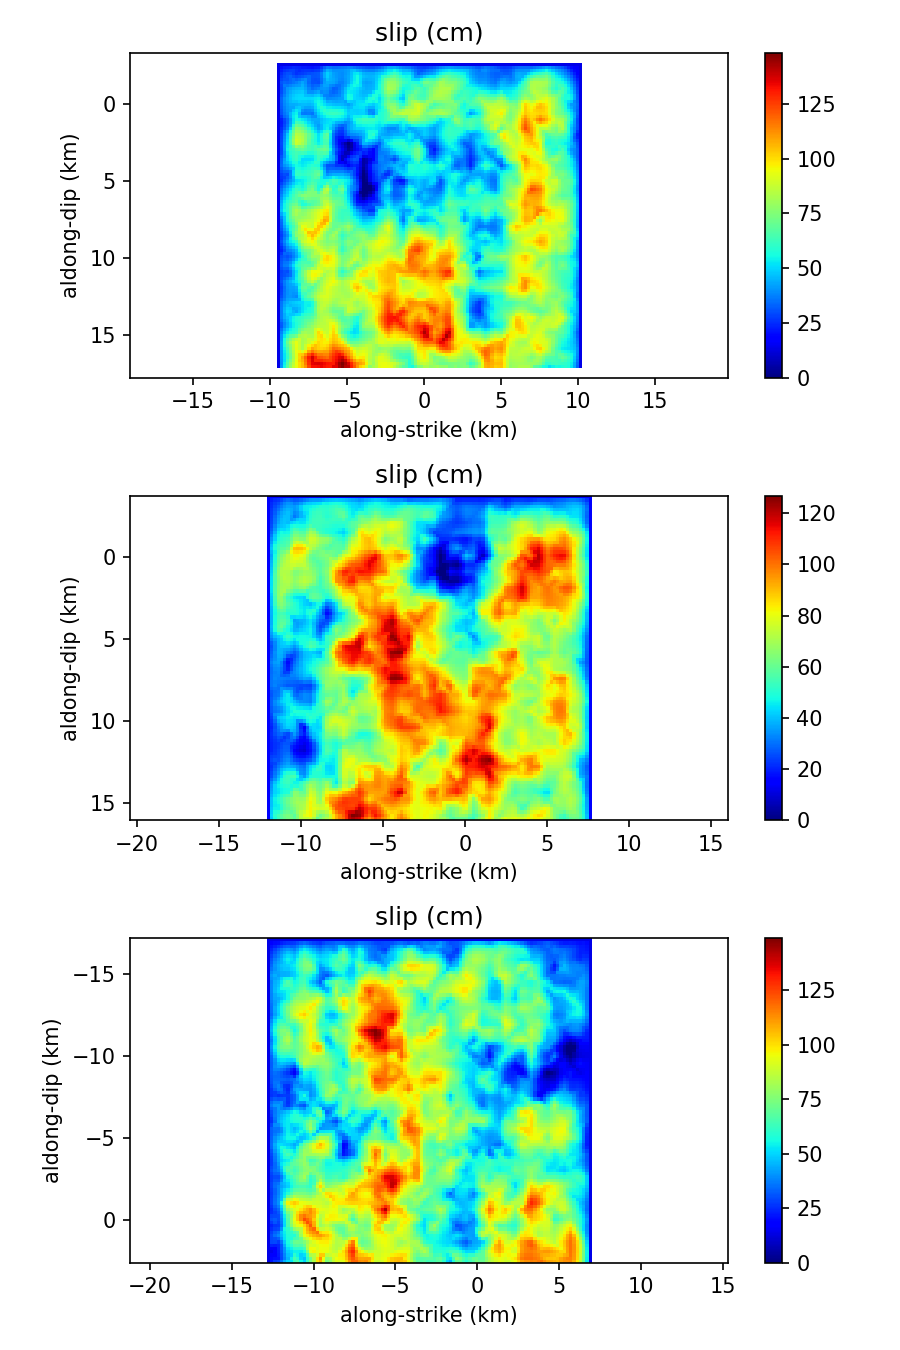

In [30]:
%matplotlib notebook
fig = plt.figure(figsize=(6,9))
for iter in range(rup["num"]):
    
  plt.subplot(rup["num"],1,iter+1)
  plt.imshow(rup["slip"][iter],extent=(rup["lx"][iter][0],rup["lx"][iter][-1],rup["lz"][iter][0],rup["lz"][iter][-1]), 
             interpolation="none")
  plt.gca().invert_yaxis()
  plt.gca().axis('equal')
 # plt.gca().axis('off')
  plt.colorbar()
  plt.jet()
  plt.title('slip (cm)')
  plt.xlabel('along-strike (km)')
  plt.ylabel('aldong-dip (km)')
    
  plt.tight_layout()
  plt.show()

<IPython.core.display.Javascript object>


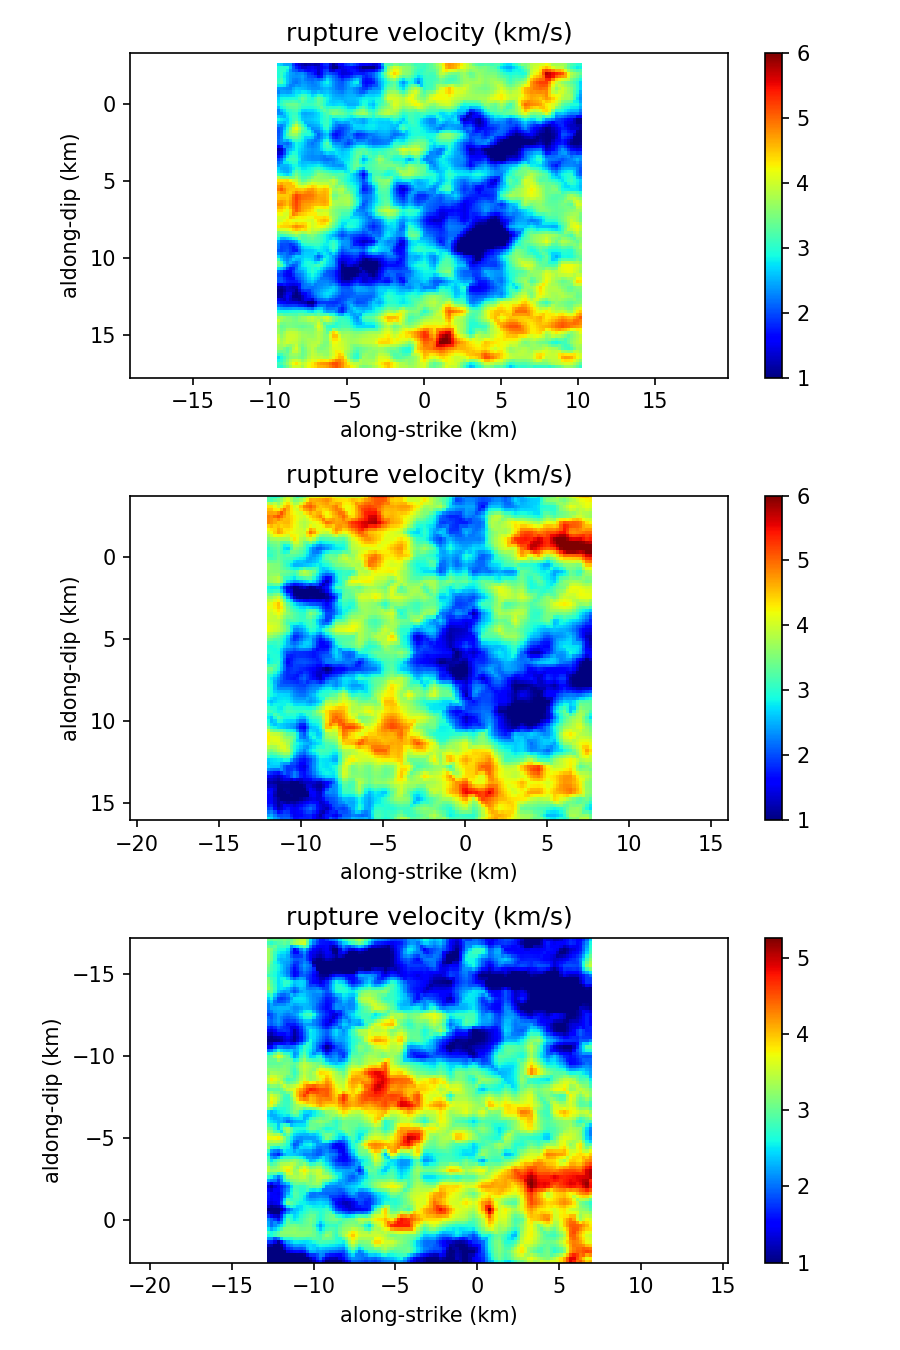

In [31]:
%matplotlib notebook
fig = plt.figure(figsize=(6,9))
for iter in range(rup["num"]):
    
  plt.subplot(rup["num"],1,iter+1)
  plt.imshow(rup["Vr"][iter],extent=(rup["lx"][iter][0],rup["lx"][iter][-1],rup["lz"][iter][0],rup["lz"][iter][-1]))
  plt.gca().invert_yaxis()
  plt.gca().axis('equal')
  #plt.gca().axis('off')
  plt.colorbar()
  plt.jet()
  plt.title('rupture velocity (km/s)')
  plt.xlabel('along-strike (km)')
  plt.ylabel('aldong-dip (km)')
    
  plt.tight_layout()
  plt.show()

<IPython.core.display.Javascript object>


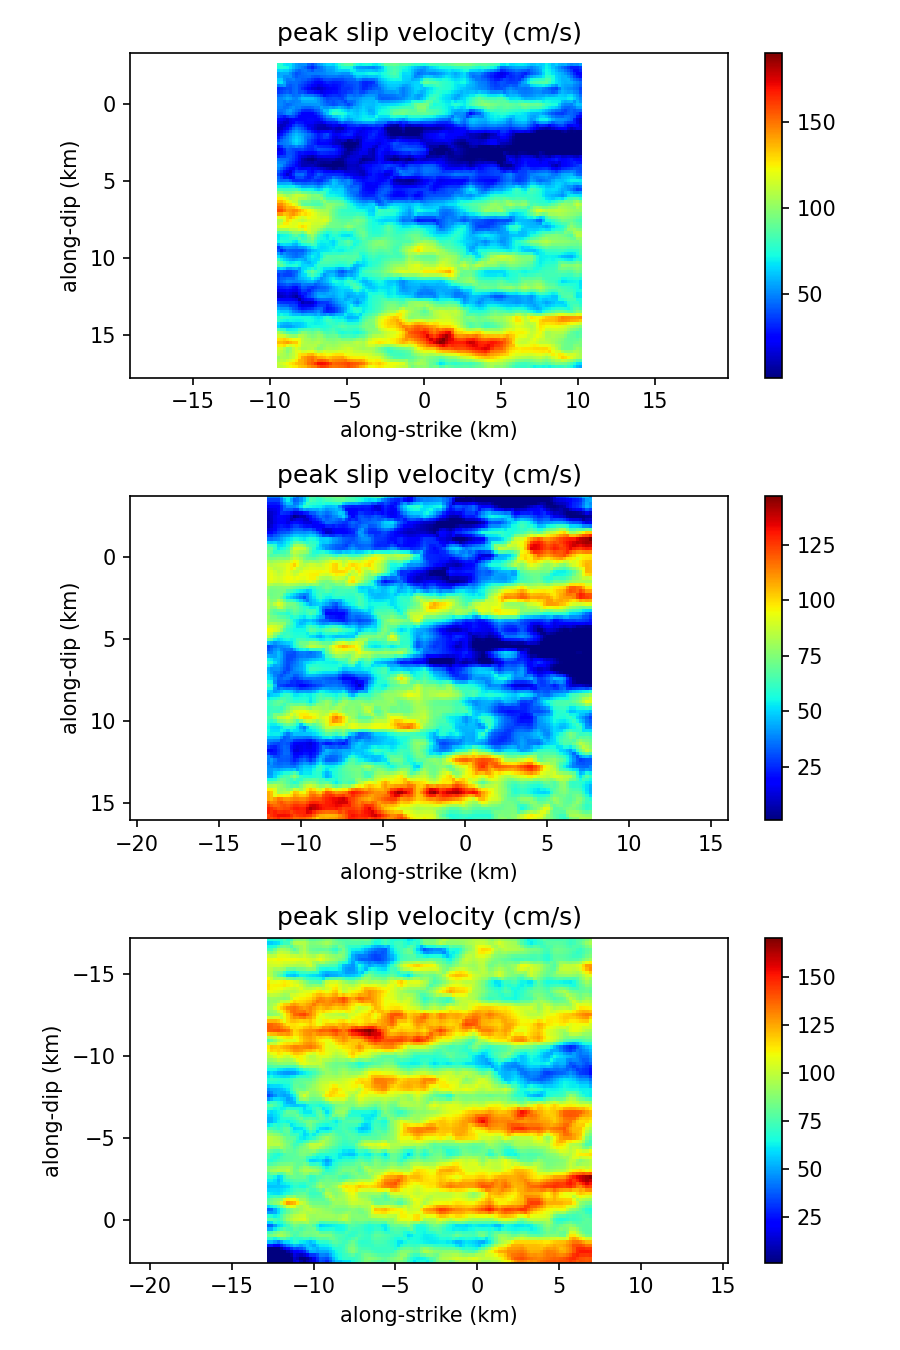

In [32]:
%matplotlib notebook
fig = plt.figure(figsize=(6,9))
for iter in range(rup["num"]):
    
  plt.subplot(rup["num"],1,iter+1)
  plt.imshow(rup["psv"][iter],extent=(rup["lx"][iter][0],rup["lx"][iter][-1],rup["lz"][iter][0],rup["lz"][iter][-1]))
  plt.gca().invert_yaxis()
  plt.gca().axis('equal')
  #plt.gca().axis('tight')
  plt.colorbar()
  plt.jet()
  plt.title('peak slip velocity (cm/s)')
  plt.xlabel('along-strike (km)')
  plt.ylabel('along-dip (km)')

  
  plt.tight_layout()
  plt.show()

In [16]:
def get_nodes(points, dx, dy):
    """
    """
    nodes = np.array([0, 0])
    nodes[0] = np.ceil(points[0] / dx)
    nodes[1] = np.ceil(points[1] / dy)
    nodes[nodes == 0] = 1.0

    return nodes

def get_points(nodes, dx, dy):
    """
    Does the opposite of get_nodes
    """
    # Scale points
    points = np.dot(np.diag([dx, dy]), nodes)
    # Subtract dx/2
    points[0] = points[0] - (dx / 2.0)
    points[1] = points[1] - (dy / 2.0)

    return points

def sub2ind(i, j, m, n):
    
    return((i + (j - 1) * m) - 1)

def ind2sub(ind, m, n):
    
    return np.unravel_index(ind, (m, n), order='F')

def is_in_domain(i, j, m, n):
    """
    Checks if i,j inside m,n
    """
    return (i >= 0) and (i < m) and (j >= 0) and (j < n)

In [17]:
def calc_time(i, j, Fij, T, frozen, m, n, dy, dx, order):
    """
    Calculates the time-distance at (i,j) from the neighboring Frozen
    pixels. The formula is the standard quadratic equation along with
    the min-max switches.
    """
    patch = np.empty((5, 5))
    patch[:] = np.inf

    for pi in range(0, 5):
        for pj in range(0, 5):
            if ((is_in_domain(i-3+pi, j-3+pj, m, n)) and
                (frozen[i-3+pi][j-3+pj])):
                patch[pi][pj] = T[i-3+pi][j-3+pj]

    # If all the surrounding cross values are inf, set the time to
    # Inf, otherwise it would results in b^2 - 4 * a(=0) *
    # c(=1/Fij=Inf)= NaN
    if min(patch[1][2], patch[3][2], patch[2][1], patch[2][3]) == np.inf:
        time = np.inf
        e_flag = 0
        return time, e_flag

    # Get the minimum vertical neighbor or don't use vertical
    # component in gradient
    oy = 0
    ymin1 = 0
    ymin2 = 0
    if not (patch[1][2] == np.inf and patch[3][2] == np.inf):
        oy = 1
        if patch[1][2] <= patch[3][2]:
            ymin1 = patch[1][2]
            if order == 2 and (patch[0][2] <= patch[1][2]):
                ymin2 = patch[0][2]
                oy = 2
        else:
            ymin1 = patch[3][2]
            if order == 2 and (patch[4][2] <= patch[3][2]):
                ymin2 = patch[4][2]
                oy = 2

    # Get the minimum horizontal neighbor or don't use horizontal
    # component in gradient
    ox = 0
    xmin1 = 0
    xmin2 = 0
    if not (patch[2][1] == np.inf and patch[2][3] == np.inf):
        ox = 1
        if patch[2][1] <= patch[2][3]:
            xmin1 = patch[2][1]
            if order == 2 and (patch[2][0] <= patch[2][1]):
                xmin2 = patch[2][0]
                ox = 2
        else:
            xmin1 = patch[2][3]
            if order == 2 and (patch[2][4] <= patch[2][3]):
                xmin2 = patch[2][4]
                ox = 2

    # Calculate coefficients of 2nd degree polynomial corresponding to
    # the time-distance equation. Coeffs: aT^2 + bT + c = 0. The
    # (ox==1) and (ox==2) act as switches. Remove all the (ox==2) and
    # what is left are the first order scheme coefficients.
    a = ((oy == 1)+9.0/4*(oy == 2))/dy**2 + ((ox == 1)+9.0/4*(ox == 2))/dx**2
    b = (((-2.0*(oy==1)-6.0*(oy == 2))*ymin1 + 3.0/2.0*(oy == 2)*ymin2)/dy**2 +
         ((-2.0*(ox==1)-6.0*(ox==2))*xmin1 + 3.0/2.0*(ox == 2)*xmin2)/dx**2)
    c = (((oy == 1)*ymin1**2 +
          (oy == 2)*(4.0*ymin1**2 + 1.0/4.0*ymin2**2 - 2.0*ymin1*ymin2))/dy**2 +
         ((ox == 1)*xmin1**2 +
          (ox == 2)*(4.0*xmin1**2 + 1.0/4.0*xmin2**2 - 2.0*xmin1*xmin2))/dx**2 -
         (1.0/Fij)**2)
    d = b**2-4.0*a*c

    # One can analytically prove that even if causality is not
    # violated (i.e. all Frozen pixels should always have lower values
    # than all narrow band pixels), complex time-dist results may
    # still arise for 2nd order schemes. This is not the case for 1st
    # order schemes, which may only yield complex results if the
    # causality aspect of the algorithm has been violated. Higher
    # order schemes are less tolerant of extreme variations in the
    # speed-map values.

    # This implementation first attempts to use the 1st order scheme
    # if the second order scheme fails. If that also fails, meaning
    # the causality has been violated (which might happen if you're
    # very unlucky, because of previous reversions,or very extreme
    # speed-map differences around the source points) we simply add
    # 1/Fij to the smallest neighbour. In case of a reversion, an
    # persistent error flag 'eFlag' is set to 1. In case of a
    # violation, it's set to 2.

    # This is better error treatment than what is used in the 'msfm'
    # (multistencil fast-marching) code imho, where any complex
    # calculation always results in [add 1/Fij to smallest neigh.],
    # and which doesn't notify the user with any error flags.
    if d < 0 and order == 2:
        # Revert to order 1
        order = 1
        (time, tmp_flag) = calc_time(i, j, Fij, T, frozen, m, n, dy, dx, order)
        e_flag = max(1, tmp_flag)
    elif d < 0 and order == 1:
        # Add 1/Fij to smallest neighbour
        if oy == 0:
            ymin1 = np.inf
        if ox == 0:
            xmin1 = np.inf
        time = min(xmin1, ymin1) + 1.0/Fij
        e_flag = 2
    else:
        # All Good!
        # Solve quadratic equation, only use the maximum root
        time = (-b+np.sqrt(d))/(2.0*a)
        e_flag = 0

    return time, e_flag

In [18]:
def fm(F, source_points, dxyz):
        """
        Implements the Fast-marching method to solve the Eikonal eqn
        in 2 dimensions
        """

        # Initialize parameters
        # ndims = 2
        m, n = F.shape
        dx = dxyz[0]
        dy = dxyz[1]

        # Check error conditions
        if not np.all(F >= 0):
            raise ValueError("F must be >= 0")

        if ((n < 1) or (m < 1)):
            raise ValueError("m and n must by > 0")

        if (dx <= 0) or (dy <= 0):
            raise ValueError("dxyz must be > 0")

        # Flip source points
        source_points = source_points[::-1]

        # Time distance matrix, initialize all points to -1
        T = np.zeros((m, n)) - 1

        # Matrix that keeps tabs on Frozen pixels
        frozen = np.zeros((m, n))

        # Construct dictionary that we use as a heap
        narrow_band = {}

        # Relative indices of the 4 neighbors to a given point
        i_offsets = [-1, 1, 0, 0]
        j_offsets = [0, 0, -1, 1]

        # Relative indices of the 8 neighbors to a given point
        i_offsets_full = [-1, -1, -1, 0, 0, 1, 1, 1]
        j_offsets_full = [-1, 0, 1, -1, 1, -1, 0, 1]

        # Initialize error flag
        e_flag = 0

        # First we calculate the time-distances to all 8 neighboring
        # pixels of the source point. This calculation is done simply
        # by taking the distance and dividing by the speed. We also
        # freeze this

        # Get node and its indice
        cp = source_points
        cp_node = get_nodes(cp, dx, dy)
        cp_ind = sub2ind(cp_node[0], cp_node[1], m, n)

        # Calculate travel time and freeze
        cp_points = get_points(cp_node, dx, dy)
        FT = T.flatten(order='F')
        FT[cp_ind] = (np.sqrt(np.dot(cp - cp_points, cp - cp_points)) /
                      F.flatten(order='F')[cp_ind])
        T = FT.reshape((m, n), order='F')
        f_frozen = frozen.flatten(order='F')
        f_frozen[cp_ind] = 1
        frozen = f_frozen.reshape((m, n), order='F')

        # For all 8 neighbors of the source point
        for neigh in range(0, 8):
            # Get index of neighbor, store as i and j
            ni = cp_node[0] + i_offsets_full[neigh]
            nj = cp_node[1] + j_offsets_full[neigh]
            n_ind = sub2ind(ni, nj, m, n)

            # Only check if is_in_domain
            if is_in_domain(ni, nj, m, n):
                val = cp - get_points([ni, nj], dx, dy)
                time = (np.sqrt(np.dot(val, val)) /
                        F.flatten(order='F')[n_ind])
                FT = T.flatten(order='F')
                if FT[n_ind] >= 0:
                    FT[n_ind] = min(time, FT[n_ind])
                else:
                    FT[n_ind] = time
                T = FT.reshape((m, n), order='F')

                f_frozen = frozen.flatten(order='F')
                f_frozen[n_ind] = 1
                frozen = f_frozen.reshape((m, n), order='F')

        # Calculate the initial narrow band as all neighboring pixels
        # to the ones that have been frozen. Note that this time,
        # unlike the source-point loop, the henceforth in the
        # algorithm, the neighbors of a pixel only include its 4
        # non-diagonal neighbors.
        for ind in range(0, m*n):
            if frozen.flatten(order='F')[ind]:
                i, j = ind2sub(ind, m, n)
                # For all 4 neighbors of the frozen points
                for neigh in range(0, 4):
                    # Get index of neighbor, store as i and j
                    ni = i + i_offsets[neigh]
                    nj = j + j_offsets[neigh]
                    n_ind = sub2ind(ni+1, nj+1, m, n)

                    # If (i,j) valid for consideration
                    if ((is_in_domain(ni, nj, m, n)) and
                        (not frozen.flatten(order='F')[n_ind])):
                        if not n_ind in narrow_band:
                            (time,
                             flag) = calc_time(ni+1, nj+1,
                                               F.flatten(order='F')[n_ind],
                                               T, frozen, m, n, dy, dx, 2)
                            narrow_band[n_ind] = time
                            e_flag = max(flag, e_flag)

        # Main Loop
        # Now start the main loop.
        # Loop until there are no more narrow band
        # neighbours, meaning the algorithm has finished
        l_count = 0
        while len(narrow_band) > 0:
            l_count = l_count + 1

            # Get min heap element.
            # This will be the new "center pixel" (CP)
            cp = min(narrow_band, key=narrow_band.get)
            time = narrow_band[cp]
            narrow_band.pop(cp)

            i, j = ind2sub(cp, m, n)
            # Freeze and set time
            f_frozen = frozen.flatten(order='F')
            f_frozen[cp] = 1
            frozen = f_frozen.reshape((m, n), order='F')
            FT = T.flatten(order='F')
            FT[cp] = time
            T = FT.reshape((m, n), order='F')

            # For all neighbours of CP
            for neigh in range(0, 4):
                # Get index of neighbor, store as i and j
                ni = i + i_offsets[neigh]
                nj = j + j_offsets[neigh]
                if not is_in_domain(ni, nj, m, n):
                    continue
                n_ind = sub2ind(ni+1, nj+1, m, n)

                # If (i,j) valid for consideration
                if ((is_in_domain(ni, nj, m, n)) and
                    (not frozen.flatten(order='F')[n_ind])):
                    (time,
                     flag) = calc_time(ni+1, nj+1,
                                       F.flatten(order='F')[n_ind],
                                       T, frozen, m, n, dy, dx, 2)
                    narrow_band[n_ind] = time

                    e_flag = max(flag, e_flag)

        return T, e_flag



In [19]:
### Step III: post-processing of generated source models
# a)rupture time calculation from simulated local rupture velocity
print('   ')
print('### Step III: Post-processing   ')
print('###   ')
t1 = time.time()
rup["rupT"] = [0]*rup["num"]
for iter in range(rup["num"]):
    
  shypo = rup["nx"]*rup["dx"]/2. + rup["shyp"][iter]
  dhypo = rup["dhyp"][iter]
    
  
  [rup["rupT"][iter], _] = fm(rup["Vr"][iter], [shypo, dhypo],[rup["dx"],rup["dz"]])


t2 = time.time() 
print("=> Elapsed time for computing rupture time distribution: {:10.2f}".format(t2-t1))


   
### Step III: Post-processing   
###   
=> Elapsed time for computing rupture time distribution:       3.98


<IPython.core.display.Javascript object>


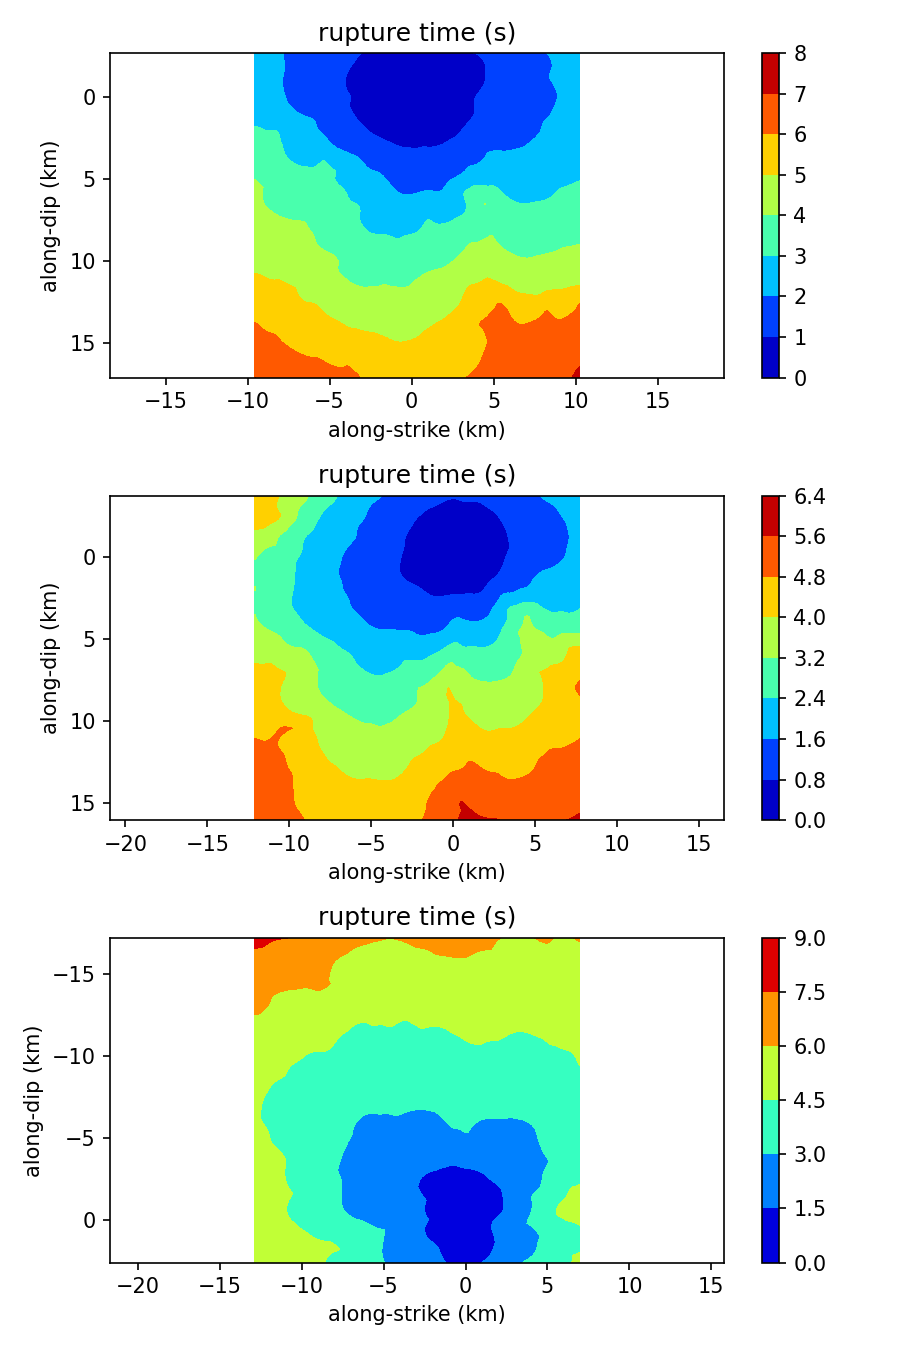

In [33]:
%matplotlib notebook
fig = plt.figure(figsize=(6,9))
for iter in range(rup["num"]):
    
  plt.subplot(rup["num"],1,iter+1)
  plt.contourf(rup["rupT"][iter],extent=(rup["lx"][iter][0],rup["lx"][iter][-1],rup["lz"][iter][0],rup["lz"][iter][-1]))
  plt.axis('equal')
  plt.gca().invert_yaxis()
  plt.colorbar()
  plt.jet()
  plt.title('rupture time (s)')
  plt.xlabel('along-strike (km)')
  plt.ylabel('along-dip (km)')
    
plt.tight_layout()
plt.show()

In [22]:
def svf_etinti(tau_s, tau_r, dt, nt):
        """
        Generating the shape of slip velocity function (SVF)
        based on Tinti et al. (BSSA, 2005)
        """
        t = np.linspace(0, (nt-1)*dt, nt)

        if tau_r < tau_s:
            raise ValueError("Tau_r should be larger than Tau_s")

        # U_tot (final slip) is one here
        K = 2.0 / (np.pi * tau_r * tau_s**2)

        # Ignore the divide by zero error
        with np.errstate(divide='ignore'):
            
            C1 = ((t / 2.0 + 1.0 / 4 * tau_r) * np.sqrt(np.array((t * (tau_r - t)), dtype=complex)) + (t * tau_r - tau_r ** 2) *
                  np.arcsin(np.sqrt(np.array((t / tau_r)), dtype=complex)) - 
                  [3.0 / 4 * tau_r ** 2 * y for y in [cmath.atan(x) for x in np.sqrt(np.array(((tau_r - t) / t), dtype=complex))]])

            C2 = 3.0 / 8 * np.pi * tau_r ** 2

            C3 = ((tau_s - t - 1.0 / 2 * tau_r) * np.sqrt(np.array(((t - tau_s) * (tau_r - t + tau_s)), dtype=complex)) +
              tau_r * (2.0 * tau_r - 2 * t + 2 * tau_s) * np.arcsin(np.sqrt(np.array(((t - tau_s) / tau_r), dtype=complex))) +
              [3.0 / 2 * tau_r ** 2 * y for y in [cmath.atan(x) for x in np.sqrt(np.array((tau_r - t + tau_s) / (t - tau_s),
                                                        dtype=complex))]])

            #C4, corrected by Bizzarri (JGR, 2012)
            C4 = ((-tau_s + 1.0 / 2.0 * t + 1.0 / 4.0 * tau_r) * np.sqrt(np.array(((t - 2 * tau_s) * (tau_r - t + 2 * tau_s)),
                dtype=complex)) + tau_r * (-tau_r + t - 2 * tau_s) *  np.arcsin(np.sqrt(np.array(((t - 2 * tau_s) / tau_r),
                dtype=complex))) - [3.0 / 4.0 * tau_r ** 2 * y for y in
                [cmath.atan(x) for x in np.sqrt(np.array((tau_r - t + 2*tau_s) / (t - 2 * tau_s), dtype=complex))]])

            C5 = np.pi / 2.0 * tau_r * (t - tau_r)

            C6 = np.pi / 2.0 * tau_r * (2.0 * tau_s - t + tau_r)

        # Filters ComplexWarning when typecasting array to float
        with warnings.catch_warnings():
          warnings.simplefilter("ignore")
          if tau_r > 2 * tau_s:
            
            svf = (np.array(((C1 + C2) * [x1 and x2 for x1, x2 in zip(t >= 0, t < tau_s)]), dtype=float) +
                  (np.array(((C1 - C2 + C3) * [x1 and x2 for x1, x2 in zip(t >= tau_s, t < 2*tau_s)]), dtype=float)) +
                  (np.array(((C1 + C3 + C4) * [x1 and x2 for x1, x2 in zip(t >= 2*tau_s, t < tau_r)]), dtype=float)) +
                  (np.array(((C5 + C3 + C4) * [x1 and x2 for x1, x2 in zip(t >= tau_r, t < tau_r + tau_s)]), dtype=float)) +
                  (np.array(((C4 + C6) * [x1 and x2 for x1, x2 in zip(t >= (tau_r + tau_s), t < (tau_r+2 * tau_s))]), dtype=float)))

          else:
            
            svf = (np.array(((C1 + C2) * [x1 and x2 for x1, x2 in zip(t >= 0, t < tau_s)]), dtype=float) +
                  (np.array(((C1 - C2 + C3) * [x1 and x2 for x1, x2 in zip(t >= tau_s, t < tau_r)]), dtype=float)) +
                  (np.array(((C5 + C3 - C2) * [x1 and x2 for x1, x2 in zip(t >= tau_r, t < 2*tau_s)]), dtype=float)) +
                  (np.array(((C5 + C3 + C4) * [x1 and x2 for x1, x2 in zip(t >= 2*tau_s, t < tau_r + tau_s)]), dtype=float)) +
                  (np.array(((C4 + C6) * [x1 and x2 for x1, x2 in zip(t >= (tau_r + tau_s), t < (tau_r+2 * tau_s))]), dtype=float)))


        svf = np.dot(K, svf)

        return svf, t
    

def gen_svf(tw, dt, nt, svf_type, t_acc):
        """
        Generating triangular or rectangular shape Slip Velocity
        Function
        """
        # Implements the 'etinti' svf_type only

        # 10% of total risetime
        #t_acc = tw * 0.1
        # Fixed T_acc
        #t_acc = par_t_acc

        tau_s = t_acc / 1.3
        tau_r = tw - 2.0 * tau_s
        if tau_r <= tau_s:
            tau_r = tau_s * 1.01
        svf, time_vec = svf_etinti(tau_s, tau_r, dt, nt)

        # All done
        return svf, time_vec

In [23]:
# b) generating slip velocity functions (SVF)
rup["svf"]["nt"] = [0]*rup["num"]
rup["svf"]["svf"] = [0]*rup["num"]
rup["svf"]["time"] = [0]*rup["num"]
rup["psv1"] = [0]*rup["num"]
for iter in range(rup["num"]):
  rup["svf"]["nt"][iter] = np.zeros((rup["nz"], rup["nx"]))
  rup["svf"]["svf"][iter] = [0]*rup["nz"]
  rup["svf"]["time"][iter] = [0]*rup["nz"]
  rup["psv1"][iter] = np.zeros((rup["nz"], rup["nx"]))
  for k in range(rup["nz"]):
    rup["svf"]["svf"][iter][k] = [0]*rup["nx"]
    rup["svf"]["time"][iter][k] = [0]*rup["nx"]
    for i in range(rup["nx"]):
        
      rup["svf"]["nt"][iter][k,i] = np.ceil((rup["risT"][iter][k,i]+0.5)/rup["svf"]["dt"]) 
      rup["svf"]["svf"][iter][k][i], rup["svf"]["time"][iter][k][i] = gen_svf(rup["risT"][iter][k,i],rup["svf"]["dt"],
                                        int(rup["svf"]["nt"][iter][k,i]),rup["svf"]["type"],rup["svf"]["T_acc"])
    
      rup["psv1"][iter][k,i] = np.max(rup["svf"]["svf"][iter][k][i])*rup["slip"][iter][k,i]           
                

t3 = time.time() 
print("=> Elapsed time for generating slip velocity functions: {:10.2f}".format(t3-t2))

=> Elapsed time for generating slip velocity functions:      33.40


In [24]:
# c) generating moment rate function
Area = rup["dx"]*rup["dz"]*1.e6
rup["mrf"]={}
rup["mrf"]["mrf"] = [0]*rup["num"]
rup["mrf"]["time"] = [0]*rup["num"]
for iter in range(rup["num"]):
    
  tlen = np.ceil(np.max(rup["rupT"][iter]) + np.max(rup["risT"][iter])) + 1.
  nt = int(tlen/rup["svf"]["dt"])
  mrf_time = np.arange(0,tlen,rup["svf"]["dt"])
  mrf = np.zeros((rup["nx"]*rup["nz"],nt))
  

  ind = 0
  for k in range(rup["nz"]):
    for i in range(rup["nx"]):
      
      i1 = int(np.round(rup["rupT"][iter][k,i]/rup["svf"]["dt"]))
      i2 = int(i1 + len(rup["svf"]["svf"][iter][k][i]))
    
      mrf[ind,i1:i2] = np.multiply(rup["mu"]*Area*rup["slip"][iter][k,i]/100.,rup["svf"]["svf"][iter][k][i])
                 
      ind = ind + 1           
                 
  rup["mrf"]["mrf"][iter]  = np.sum(mrf, axis=0)
  rup["mrf"]["time"][iter] = mrf_time


t4 = time.time()
print("=> Elapsed time for generating moment rate function: {:10.2f}".format(t4-t3))


=> Elapsed time for generating moment rate function:       0.19


<IPython.core.display.Javascript object>


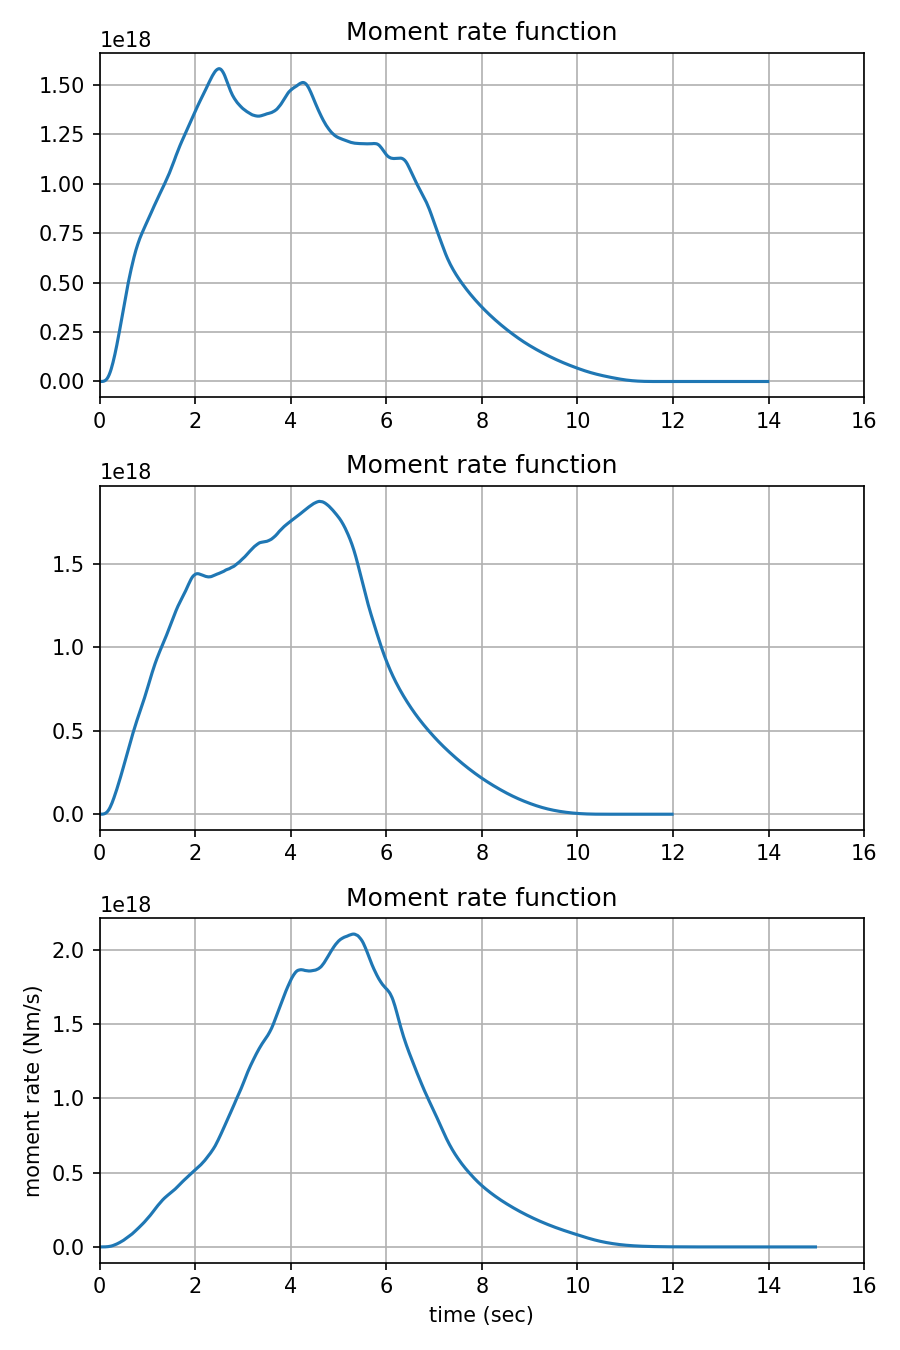

In [34]:
%matplotlib notebook
fig = plt.figure(figsize=(6,9))
for iter in range(rup["num"]):
  plt.subplot(rup["num"],1,iter+1)
  plt.plot(rup["mrf"]["time"][iter],rup["mrf"]["mrf"][iter])
  plt.grid()
  plt.xlim(0,16)
  plt.title('Moment rate function')
 

plt.xlabel('time (sec)')
plt.ylabel('moment rate (Nm/s)')
plt.tight_layout()
plt.show()